### IMPORTANT TO DOs - remove from the submission to AWS

<p>
__!!!_ADD A SIDEBAR TO THE NOTEBOOK_!!!__
<br>
https://github.com/ipython-contrib/jupyter_contrib_nbextensions
<p>
#### Refactor the code. Create functions for plotting, dummy variables creation, crosstabulation, etc.



### Reduce maintenance cost through predictive techniques
___Valentin Todorov (January 2018)___

#### Background
Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry
attributes.

Predictive maintenance techniques are designed to help determine the condition of in-service
equipment in order to predict when maintenance should be performed. This approach
promises cost savings over routine or time-based preventive maintenance, because tasks are
performed only when warranted.

#### Goal:
You are tasked with building a predictive model using machine learning to predict the
probability of a device failure. When building this model, be sure to minimize false positives and
false negatives. The column you are trying to predict is called failure with binary value 0 for
non-failure and 1 for failure.

#### Data
Download link: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv

#### Plan for development
1. Read the data
2. Data exploration
    * Calculate the distribution of total fail/not fail cases
    * Distribution of fail/not-fail cases by year
    * Distribution of fail/not-fail cases by month
    * Are there any devices that have higher failure rates than others
    * When a device fails, does it disappear from the data, or does it show up again
    * Are there particular days of the week when a higher percent of devices fail?
3. Understand the important variables for splitting the dataset
    * Do a pre-modeling analysis using decision trees
    * Use decision trees to understand which are the important drivers for the outcome
4. Derive new features
    * Determine which features are categorical, and if needed create dummies
    * Since the data for some of the features is very sparse, create dummies which are 1, if data is available and 0 otherwise
    * Use decision trees to decide how to split by categories of attributes
    * Should I do PCA? (likely no..)
5. Sampling of the data (70/30)
    * Create random samples from the data - 70% for training and 30% for validation
    * If the failures are too few compared to the non-failures, I will need to oversample the failures (and add a weight), or simply undersample the non-failures
    * Dealing with imbalanced datasets (https://datascience.stackexchange.com/questions/9488/xgboost-give-more-importance-to-recent-samples)
6. Do we need separate models for different groups of devices?
    * Use decision trees to figure this out
        * Run decision trees on all devices
        * Run decision trees by types of devices, determined by the first letter - S, W, or Z
7. Variables reduction
    * Use decision trees
    * Use p-values
    * LASSO
    * Random forest's variable importance
    * Stepwise logistic regression
    * Compare the suggested features from each method
8. Decide on a methodology for the model estimation
    * Random forest
    * Random forest with XG boosting
    * Random forest with ADA
    * SVM
    * Penalized-SVM
    * Neural network
    * Logistic regression
9. Validate the results
10. Accuracy measures
    * Calculate c-statistic and ROC
    * Plot the performance for multiple modles using the area under the curve (AUC) graph
    * Create a deciles table with lift, and graph it
    * Sensitivity/Recall
    * Specificity
11. Create a confusion matrix - reduce false positives and false negatives
12. Does the methodology we use allow us to understand what drives the outcome? If it doesn't, do we need another methodology that can help with that?


In [190]:
import pandas as pd
import numpy as np
from decimal import *
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
#from imblearn.over_sampling import SMOTE
import graphviz
import matplotlib.pyplot as plt
#from __future__ import print_function

%matplotlib inline

# This defines the path to the data depending on the OS I use - Win or mac OS
def selectOS(_os):
    if _os == "win":
        data_location = "C:/Users/bre49823/GoogleDrive/Data/aws/device_failure.csv"
    elif _os == "mac":
        data_location = "/Users/valentin/GoogleDrive/Data/aws/device_failure.csv"
    return data_location

# Read in the data and print out the header
device_data = pd.read_csv(selectOS("win"))

# Check if the number of rows is as expected
print (len(device_data))

device_data.head(10)

124494


date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   
5  2015-01-01  S1F01TD5        0    68837488           0           0   
6  2015-01-01  S1F01XDJ        0   227721632           0           0   
7  2015-01-01  S1F023H2        0   141503600           0           0   
8  2015-01-01  S1F02A0J        0     8217840           0           1   
9  2015-01-01  S1F02DZ2        0   116440096           0         323   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3  
5          41           6      413535           0           0           1  
6           0           8      402525           0           0           0  
7           1          19      494462          16          16           3  
8           0          14      311869           0           0           0  
9           9           9      407905           0           0         164

Whenever I start working with a dataset I've never seen, I like to open it as a SQL table, or import it in Excel, and familiarize myself with it. If the file is small enough, and Excel can handle it, I'll import the whole file, otherwise, I take a random sample from it, small enough that can be easily processed within the available RAM and CPU.

Next, I usually create a pivot table in Excel and try to understand what features are available. Are there dates - if there are, what is the time range coverered? When we know the dates from the data, we can relate them to important Macroeconomic environments - major crises, stock market and crude oil price crashes, etc. Most of the real world industry processes are impacted by economic events. For example, if the data in the provided dataset spans back to 2007, it is very likely that we'll see structural shifts in some of the attributes during the period 2008 - 2009.

In [91]:
# Calculate the distribution of total fail/not fail cases
pct_fail_cases = sum(device_data["failure"]) / len(device_data["failure"]) * 100
print("It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.")
print("Only %s of the cases are device failures" % pct_fail_cases)

It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.
Only 0 of the cases are device failures


In [92]:
# Check if there are NA values in the data
# If the list with features is very long I wouldn't print the whole list with the results, but will only print those that with missing values
columns_list = list(device_data.columns)
features_na = []

for i in range(0, len(columns_list)):
    col = columns_list[i]
    features_na.append(device_data[col].isnull().sum())

print (zip(columns_list, features_na))

[('date', 0), ('device', 0), ('failure', 0), ('attribute1', 0), ('attribute2', 0), ('attribute3', 0), ('attribute4', 0), ('attribute5', 0), ('attribute6', 0), ('attribute7', 0), ('attribute8', 0), ('attribute9', 0)]


There are no features with NULL or NaN values..

In [93]:
# Create dummies from the attributes
# If the value of an attribute is larger than 0, encode as 1, otherwise 0
columns_list = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute8", "attribute9"]
column_dummy_idx = []

for col in columns_list:
    column_dummy = col + "_dummy"
    device_data[column_dummy] = [1 if x > 0 else 0 for x in device_data[col]]
    column_dummy_idx.append(column_dummy)
    
print zip(column_dummy_idx, [device_data[s].value_counts() for s in column_dummy_idx])

[('attribute1_dummy', 1    124483
0        11
Name: attribute1_dummy, dtype: int64), ('attribute2_dummy', 0    118110
1      6384
Name: attribute2_dummy, dtype: int64), ('attribute3_dummy', 0    115359
1      9135
Name: attribute3_dummy, dtype: int64), ('attribute4_dummy', 0    115156
1      9338
Name: attribute4_dummy, dtype: int64), ('attribute5_dummy', 1    124494
Name: attribute5_dummy, dtype: int64), ('attribute6_dummy', 1    124494
Name: attribute6_dummy, dtype: int64), ('attribute7_dummy', 0    123036
1      1458
Name: attribute7_dummy, dtype: int64), ('attribute8_dummy', 0    123036
1      1458
Name: attribute8_dummy, dtype: int64), ('attribute9_dummy', 0    97358
1    27136
Name: attribute9_dummy, dtype: int64)]


From the analysis of observations when the values of each attribute is larger than 0, it looks like attributes 7 & 8 have the same number of cases when they are larger than 0. This requires a little more investigation. If both attributes have the same values, one of them will be dropped.
<p>
Next, I'll test if the values for attributes 7 & 8 are the same. I'll simply subtract attribute 7 from 8 and sum up the differences. If the sum is 0, then all the values for 7 & 8 are the same, and I'll drop column 8.

In [94]:
sum((device_data["attribute7"] - device_data["attribute8"]))

0

Based on the test, columns 7 & 8 are the same. Hence, I'll drop column 8.

In [95]:
drop_vars = ["attribute8", "attribute8_dummy"]
device_data = device_data.drop(drop_vars, axis = 1)

We need to dig a little deeper into the distributions of failure/non-failure and understand the following:
1. Distribution of failure/non-failure by year
2. Distribution of failure/non-failure by month
3. Distribution of failure/non-failure by device - are there specific devices that tend to fail more than others?

In [96]:
# Distribution of failure/non-failure by year
device_data["year"] = pd.to_datetime(device_data["date"]).dt.year
device_data["month"] = pd.to_datetime(device_data["date"]).dt.month
device_data["day_of_week"] = pd.to_datetime(device_data["date"]).dt.dayofweek
device_data["device_type"] = device_data.device.str[0]

# Create dummies for each of the three different devices in the data. Each starts with a different letter - S, W, or Z
device_data = pd.concat([device_data, pd.get_dummies(device_data["device_type"].str.lower(), prefix = "device_type")],
                        axis = 1, join_axes = [device_data.index])

# One-hot encode the failure variable
# failure_outcome = pd.get_dummies(device_data.failure)

# Print some summary stats
print(device_data.failure.value_counts())

print(pd.crosstab(device_data["year"],
                  columns = "count"))
pd.crosstab(device_data["month"],
            columns = "count") / len(device_data.month)

0    124388
1       106
Name: failure, dtype: int64
col_0   count
year         
2015   124494


col_0     count
month          
1      0.201070
2      0.156634
3      0.159309
4      0.096487
5      0.091008
6      0.084092
7      0.084590
8      0.067039
9      0.035905
10     0.023616
11     0.000249

It is evident that the data is only for 2015 and we have information for most of the months of 2015, except for December. However, note that 50% of the observations are from the period January - March.
<p>
Next, we'll look at the distribution of failure/non-failure by month

In [97]:
# Distribution of failure/non-failure by month
failure_month = pd.crosstab(index = device_data["failure"],
                            columns = device_data["month"],
                            margins = True)

failure_month.index = ["non_failure", "failure", "month_total"]
failure_month

month            1      2      3      4      5      6      7     8     9  \
non_failure  25008  19486  19824  12003  11309  10463  10515  8342  4470   
failure         24     14      9      9     21      6     16     4     0   
month_total  25032  19500  19833  12012  11330  10469  10531  8346  4470   

month          10  11     All  
non_failure  2937  31  124388  
failure         3   0     106  
month_total  2940  31  124494

In [98]:
failure_month_pct = failure_month / failure_month.loc["month_total"]
failure_month_pct

month               1         2         3         4         5         6  \
non_failure  0.999041  0.999282  0.999546  0.999251  0.998147  0.999427   
failure      0.000959  0.000718  0.000454  0.000749  0.001853  0.000573   
month_total  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

month               7         8    9       10   11       All  
non_failure  0.998481  0.999521  1.0  0.99898  1.0  0.999149  
failure      0.001519  0.000479  0.0  0.00102  0.0  0.000851  
month_total  1.000000  1.000000  1.0  1.00000  1.0  1.000000

Text(0.5,1,u'Percent Failed Devices by Month')

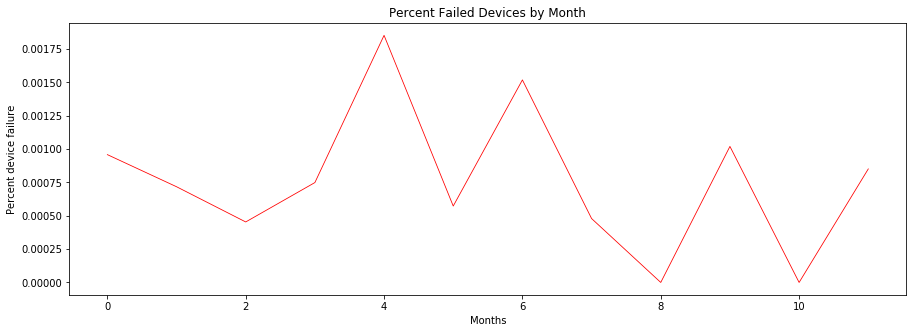

In [99]:
# Plot the % failures/non-failures by month
plt.figure(figsize = (15, 5))
plt.plot(list(failure_month_pct.loc["failure"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

In [100]:
failure_day = pd.crosstab(index = device_data["date"],
                          columns = device_data["failure"],
                          margins = True)

failure_day.columns = ["non_failure", "failure", "total"]
failure_day

non_failure  failure   total
date                                    
2015-01-01         1163        0    1163
2015-01-02         1163        0    1163
2015-01-03         1163        0    1163
2015-01-04         1162        0    1162
2015-01-05         1160        1    1161
2015-01-06         1054        0    1054
2015-01-07          797        1     798
2015-01-08          756        0     756
2015-01-09          755        1     756
2015-01-10          755        0     755
2015-01-11          755        0     755
2015-01-12          755        0     755
2015-01-13          754        1     755
2015-01-14          715        1     716
2015-01-15          715        0     715
2015-01-16          715        0     715
2015-01-17          714        1     715
2015-01-18          713        1     714
2015-01-19          705        8     713
2015-01-20          712        1     713
2015-01-21          712        0     712
2015-01-22          711        1     712
2015-01-23          710        2     712
2015-01-24          712        0     712
2015-01-25          712        0     712
2015-01-26          711        1     712
2015-01-27          711        1     712
2015-01-28          711        1     712
2015-01-29          713        2     715
2015-01-30          712        0     712
...                 ...      ...     ...
2015-10-03          146        0     146
2015-10-04          146        0     146
2015-10-05          145        1     146
2015-10-06          141        0     141
2015-10-07          141        0     141
2015-10-08          141        0     141
2015-10-09          140        1     141
2015-10-10          140        0     140
2015-10-11          140        0     140
2015-10-12          140        0     140
2015-10-13          111        0     111
2015-10-14          111        0     111
2015-10-15          109        0     109
2015-10-16          109        0     109
2015-10-17          109        0     109
2015-10-18          109        0     109
2015-10-19          109        0     109
2015-10-20           69        0      69
2015-10-21           69        0      69
2015-10-22           69        0      69
2015-10-23           32        0      32
2015-10-24           32        0      32
2015-10-25           32        0      32
2015-10-26           31        1      32
2015-10-27           31        0      31
2015-10-29           31        0      31
2015-10-30           31        0      31
2015-10-31           31        0      31
2015-11-02           31        0      31
All              124388      106  124494

[305 rows x 3 columns]

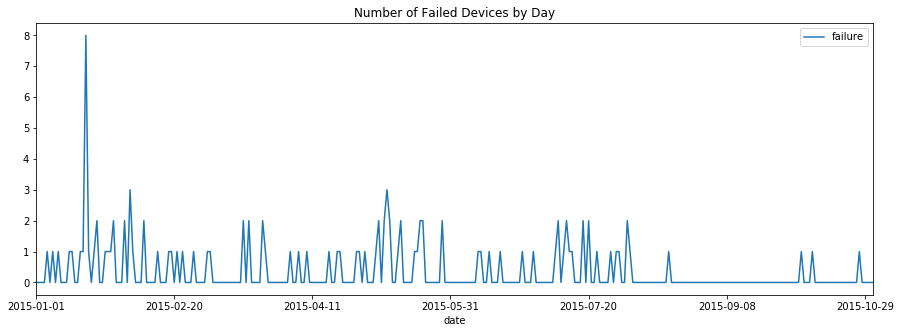

In [101]:
# Plot the % failures/non-failures by day
failure_day[:-1].reset_index().plot(x = "date", y = "failure",
                                    figsize = (15, 5),
                                    title = "Number of Failed Devices by Day")

In [142]:
# Distribution of failure/non-failure by device type - are there specific devices that tend to fail more than others?
failure_device = pd.crosstab(index = device_data["device_type"],
                             columns = device_data["failure"],
                             margins = True)
failure_device.columns = ["non_failure", "failure", "total"]

print (failure_device["failure"] / failure_device["total"])
failure_device

device_type
S      0.000766
W      0.000971
Z      0.000834
All    0.000851
dtype: float64


non_failure  failure   total
device_type                              
S                  54816       42   54858
W                  43226       42   43268
Z                  26346       22   26368
All               124388      106  124494

In [103]:
# Are there particular days of the week when a higher percent of devices fail?
failure_day_week = pd.crosstab(index = device_data["day_of_week"],
                               columns = device_data["failure"],
                               margins = True)
failure_day_week

failure           0    1     All
day_of_week                     
0             17859   27   17886
1             17516   18   17534
2             17121   15   17136
3             18119   22   18141
4             18029   12   18041
5             17889    8   17897
6             17855    4   17859
All          124388  106  124494

In [104]:
device_data.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7      ...        \
0          52           6      407438           0      ...         
1           0           6      403174           0      ...         
2           0          12      237394           0      ...         
3           0           6      410186           0      ...         
4           0          15      313173           0      ...         

   attribute6_dummy  attribute7_dummy  attribute9_dummy  year  month  \
0                 1                 0                 1  2015      1   
1                 1                 0                 0  2015      1   
2                 1                 0                 0  2015      1   
3                 1                 0                 0  2015      1   
4                 1                 0                 1  2015      1   

   day_of_week  device_type  device_type_s  device_type_w  device_type_z  
0            3            S              1              0              0  
1            3            S              1              0              0  
2            3            S              1              0              0  
3            3            S              1              0              0  
4            3            S              1              0              0  

[5 rows x 26 columns]

In [105]:
# Build a decision tree to understand how the data should be split
y_train = device_data[["failure"]]
x_train = device_data[["attribute1", "attribute2", "attribute3", "attribute4", "attribute5",
                       "attribute6", "attribute6", "attribute9", "day_of_week", "device_type_s",
                       "device_type_w", "device_type_z"]]

# Specify the decision tree model and fit it
decisionTree = DecisionTreeClassifier(criterion = "gini",
                            random_state = 99,
                            max_depth = 3,
                            min_samples_split = 20)
decisionTree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

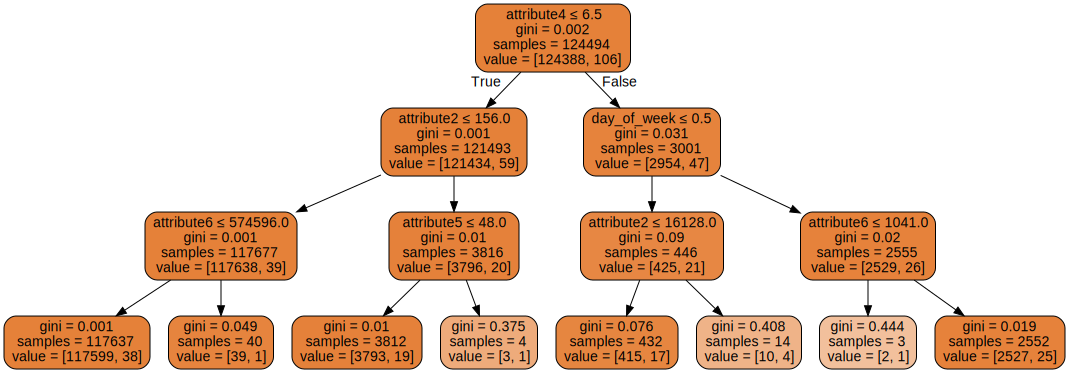

In [106]:
# Visualize the decision tree

# Export the data from the decision tree as a DOT object
dt_model_data = export_graphviz(decisionTree, out_file = None,
#                                class_names = list(y_train),
                                feature_names = list(x_train),
                                filled = True, rounded = True,
                                special_characters = True)

# Plot the tree
graphviz.Source(dt_model_data)

In [108]:
# Prepare the data for the models
# Drop certain variables
drop_from_analysis = ["date", "device", "year", "month", "device_type"]
analysis_set = device_data.drop(drop_from_analysis, axis = 1)


Next, we need to create training and validation datasets to use in modeling. It is very important that when we create training and validation datasets, the rate of failure in those datasets remains the same as in the full set. If it's not the same as in the original dataset, our accuracy stats on the developed model will be wrong and cannot be trusted.
<p>
My initial plan for creating train and validation datasets was to use train_test_split() from sklearn. However, I was suspicious that with such a low rate of failure in the input dataset (0.000851), the train_test_split() function will not properly sample the data, and the resulting rates will be different.
<p>
I re-ran the sampling a couple of times, and in one of the draws, the training ended up having a failure rate which was about 1.5 times higher than in the original, or the validation sets.
<p>
Therefore, I implemented my sampling from the original set.

In [286]:
x_train, x_validate, y_train, y_validate = train_test_split(analysis_set.drop(["failure"], axis = 1),
                                                            analysis_set["failure"],
                                                            train_size = .3)

# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print "The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts()))
print "The rate of failures in the training set is " + str(Decimal(float(y_train.value_counts()[1])) / sum(y_train.value_counts()))
print "The rate of failures in the validation set is " + str(Decimal(float(y_validate.value_counts()[1])) / sum(y_validate.value_counts()))

#The rate of failures in the original set is 0.0008514466560637460439860555529
#The rate of failures in the training set is 0.001071007818357074006640248474
#The rate of failures in the validation set is 0.0007573497349275927753425286301

The rate of failures in the original set is 0.0008514466560637460439860555529
The rate of failures in the training set is 0.0008568062546856592053121987791
The rate of failures in the validation set is 0.0008491497027976040208385927065


Split the data into training and validation, and prepare for modeling.

In [287]:
# Split the data into training and validation - there are so few cases that using the train_test_split function to split the dataset creates sets with different cases rates
# Need to oversample the cases OR under-sample the non-cases
# Create a training set - pull a 30% random sample without replacement from the training set

sample_size = .3
_failure = analysis_set[analysis_set["failure"] == 1]
_non_failure = analysis_set[analysis_set["failure"] == 0]

_failure_t = _failure.sample(frac = sample_size,
                             replace = False,
                             weights = None,
                             random_state = 7894)

_x_train_t = _failure_t.drop(["failure"], axis = 1)
_y_train_t = _failure_t["failure"]




# Create validation set - the validation set is the remaining 70%
#x_validate = 
#y_validate = 


# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print "The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts()))
print "The rate of failures in the training set is " + str(Decimal(float(y_train.value_counts()[1])) / sum(y_train.value_counts()))
print "The rate of failures in the validation set is " + str(Decimal(float(y_validate.value_counts()[1])) / sum(y_validate.value_counts()))

The rate of failures in the original set is 0.0008514466560637460439860555529
The rate of failures in the training set is 1
The rate of failures in the validation set is 0.0008491497027976040208385927065


In [238]:
len(analysis_set_non_failure)

124388

In [116]:
# Random Forest classifier
model_rf = RandomForestClassifier(n_estimators = 25, random_state = 7894,
                                  verbose = 0)
model_rf.fit(x_train, y_train)

print "Test Results"
print model_rf.score(x_train, y_train)
print recall_score(y_train, model_rf.predict(x_train))

print "\nValidation Results"
print model_rf.score(x_validate, y_validate)
print recall_score(y_validate, model_rf.predict(x_validate))

Test Results
0.999973224805
0.96

Validation Results
0.999047575333
0.0


In [ ]:
# Random forest with XGB boost
model_rf_xgb

In [ ]:
# Random forest with ADA boost
model_rf_ada

In [ ]:
# Neural network
model_nn

In [ ]:
# Logistic regression
model_lr

In [114]:
training_features, test_features, \
training_target, test_target, = train_test_split(loans_relevant_enconded.drop(['bad_loans'], axis=1),
                                               loans_relevant_enconded['bad_loans'],
                                               test_size = .1,
                                               random_state=12)

x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)
                                                 
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

print 'Validation Results'
print clf_rf.score(x_val, y_val)
print recall_score(y_val, clf_rf.predict(x_val))
print '\nTest Results'
print clf_rf.score(test_features, test_target)
print recall_score(test_target, clf_rf.predict(test_features))

NameError: name 'loans_relevant_enconded' is not defined

In [ ]:
# Train a simple model
clf_0 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_0 = clf_0.predict(X)

# How's the accuracy?
print(accuracy_score(pred_y_0, y))

# Should we be excited?
print(np.unique(pred_y_0))